In [ ]:
from __future__ import division
from pylab import *             # includes numpy
import matplotlib.pyplot as plt # plotting libraries from matlab
import sys
sys.path.insert(2, '//global/project/projectdirs/lux/data')
sys.path.insert(2,'/global/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages')
import scipy 
import scipy.interpolate as ip
import aLib
import scipy.io as sio
import pandas as pd
import libNEST

%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 18})

<h1> Setup NEST </h1>

In [2]:
Xe_density=2.863
PT=1 #ER Particle Type
En=10 #energy, doesn't matter here

#Construct the NEST object
NEST=libNEST.NEST(PT,En,-1,Xe_density,-1) #PT, Energy, EField - Doesn't matter, density, dT
#Construcrt a detector object and start with LUX
myDet=libNEST.Detector()
myDet.LUXSettings()

<h1> Modify NEST Parameters </h1>

In [3]:
#now modify your detector settings before passing it into NEST

#General settings
myDet.g1=0.098 #phd per S1 photon in liquid at dtCntr (not phe)- From Kr2p20 Result
myDet.sp=0.37 #single phe resolution (Gaussian assumed)
myDet.eDriftSpeed=1.47 #mm/usec
myDet.liquidBorder=544.2198 #mm
myDet.af=6555 #field in V/cm between liquid/gas border and anode
myDet.nFold=2 #how many PMTs have to fire for an S1 to count
myDet.spEff = 0.3; #POD threshold in phe
myDet.spEff_direct = 1; #actual efficiency, used in lieu of POD threshold
myDet.dt_min=40 #minimum. Top of detector fiducial
myDet.dt_max=300 #maximum. Bottom of detector fiducial
r_max=18 #Not a NEST parameter.  This is the radial cut used in the Kr chi2 code
myDet.s2_thr=150 #the S2 threshold in phd. Effects NR most
myDet.s2_rat=0.449 #S2 bottom/total ratio, not really used anymore
myDet.gasGap=0.56 #EL gap in cm, effecting both field and linear S2 term
myDet.elGain=0.140 #slope term for S2 photons per electron formula
myDet.elThld=0.474 #intercept term, setting minimum field to see S2
myDet.P_dphe=0.173 #chance 1 photon makes 2 phe instead of 1 in PMT
myDet.vuv1_1to1_2=1 #correction between different gain versions in LUX
myDet.coinWind=100 #S1 concidence window in ns
myDet.ee=0.808 #extraction efficiency, overriding estimate from field, assumed unchanged from Sep2014



#Sep 2015 specific settings
myDet.g1_gas=0.087 #phd per S2 photon in gas, used to get SE size
myDet.ff=1.2567 #Fano-like fudge factor for SE width
myDet.s1polA=1.1776 #S1 PDE quartic poly for function of z: s1polA + s1polB*z[mm] + s1polC*z^2+... (QE included, for binomial)
myDet.s1polB=-9.9730e-04
myDet.s1polC=7.7223e-07
myDet.s1polD=0
myDet.s1polE=0
myDet.dtCntr=163.4 #center of detector for S1 corrections, in usec.
myDet.e_life= 1400#Electron liftime in us
myDet.gasRho=17.8e-3 #gas density in g/cm^3 based on T and P of detector
myDet.numberPMTs1= 117 #in LUX, 122 minus 3 de-activated. For coincidence
myDet.numberPMTs= 117 #in LUX, 122 minus 3 de-activated. For coincidence
myDet.Xe_rho=2.863 #for slight adjustment NEST uses liquid density. g/cm^3


#Electric field polynomial values don't matter, since we are drawing from Lucie's Map


#pass the detector object into NEST.
NEST.SetDetectorParameters(myDet)

<h1> Get S1 S2 for tritium beta spectrum with LUX detector settings </h1>

<h1> 
Define a tritium beta spectrum, http://www.hindawi.com/journals/ahep/2013/293986/
</h1> 

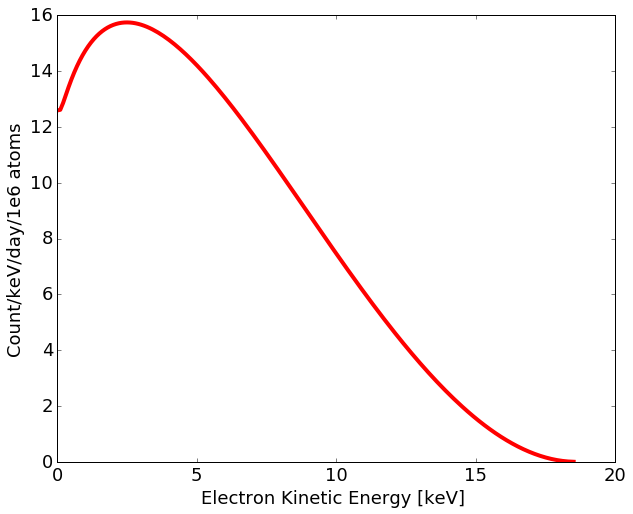

In [4]:
c=1;    # speed of light
C=1e-6; #constant infront of Fermi funciton. Arbitrary. Read Katrin paper if you care about super-allowed and allowed transitions... and nuclear matrix elements that don't matter
me = 511/c**2; # rest mass of our good friend the electron, in keV
Q=18.6 # endpoint of the tritium Beta decay keV. Maximum kinetic energy the electron.
mv=0   # neutrino mass=0. There may exist a 17 keV neutrino, maybe 7 keV!! Will we ever know??? Is it The Dark Matter?? Mystery...
step_T=0.1 #step energy by 0.1 keV
T=arange(0.01, 18.6,step_T) #sweep from 0.01 to the Q value in increments of step_T.
Z=1+1; #Tritium, after the beta decay Z'=1+1;
halflife = 12.32; # half life of the tritium beta decay in years
tau = 365*halflife/0.69; # Decay constant converted to days
n = 1e6; # Assume 1e6 atoms are decaying.
G=(T+me*c**2)/(me*c**2); #Gamma, Total energy(E+M^2) over M^2
B=sqrt((G**2-1)/G**2); # v/c of electron. Ratio of velocity to speed of light in vacuum.
x=(2*pi*Z/137)/B; # note: fine structure constant = 137. 
F_Kat=x*(1/(1-exp(-x))); # Katrin paper... http://www.hindawi.com/journals/ahep/2013/293986/ (really the same thing)
KE=T; #(G-1).*me*c^2; % The kinetic energy, is equal to T
E=KE+me*c**2; # the total energy. KE + rest mass
P=sqrt(E**2-me**2*c**4)/c; # momentum of the electron
N=C*F_Kat*(KE+me)*sqrt((KE+me)**2-me**2)*(Q-KE)**2 # eqution 18 of Katrin paper. Set nutrino mass to zero... http://www.hindawi.com/journals/ahep/2013/293986/ (really the same thing)
s = sum(N[~isnan(N)])*step_T # Total Counts
N = N * (1/s * n/tau) # Decays/keV/day/1e6 atoms

#plot to se beta spectrum for tritium 
figure(0)
plt.plot(T,N,'r',linewidth=4)
plt.xlabel('Electron Kinetic Energy [keV] ',fontsize=18)
plt.ylabel('Count/keV/day/1e6 atoms',fontsize=18)

<h1> Load Lucie's Sep2015 Field Map </h1>

In [6]:
mat = sio.loadmat('/global/homes/r/rknoche/Sep2015_3DFieldMap_ForPython_v1p0.mat')
x_bins=mat['x_bins'] #in cm
y_bins=mat['y_bins'] #in cm
z_bins=mat['z_bins'] #in mm with cathode at z=0
DriftTimeMap=mat['DriftTimeMap'] #in uSec
FieldMap=mat['FieldMap']/100 #in V/cm 
FieldMap

#Convert dT min/max to Z max/min (in mm) using Lucie's Map
#dTtoZ=0.001082343551729*dT**2  -1.836729127595990*dT + 482.0536 #2015 conversion based on Lucie's map -- From CC:\Program Files\MATLAB\R2012a\bin\LUXCode\Scratch\RichardKnoche\KrypCal_RD\KrypCal_2p21\TritiumMethod\Run04_G1ZDep_Sep2015
#dTtoZ=0.001155011585870*dT**2  -1.855642880280688*dT + 482.6349 #2016 conversion based on Lucie's map -- From CC:\Program Files\MATLAB\R2012a\bin\LUXCode\Scratch\RichardKnoche\KrypCal_RD\KrypCal_2p21\TritiumMethod\Run04_G1ZDep_Feb2016


z_max= 0.001082343551729*myDet.dt_min**2-1.836729127595990*myDet.dt_min+482.0536 #convert zmin in uSec to zmin in mm using Lucie's Map
z_min= 0.001082343551729*myDet.dt_max**2-1.836729127595990*myDet.dt_max+482.0536 #convert zmax in uSec to zmax in mm using Lucie's Map

In [7]:
x_bins=np.squeeze(x_bins)
y_bins=np.squeeze(y_bins)
z_bins=np.squeeze(z_bins)

In [8]:
xyz_to_field=ip.RegularGridInterpolator((x_bins,y_bins,z_bins),FieldMap)
xyz_to_dT=ip.RegularGridInterpolator((x_bins,y_bins,z_bins),DriftTimeMap)

#interp_val=fn((-15,15,400))

<h1> Simulate, updating energy, dT, eField at each event </h1>

In [9]:
#####
trial_m=500; # about 150k with trial_m = 100
trials=sum(ceil(N*trial_m)); #tritium dN/dE is fractional so multiply amplitute. 
subtrials=np.zeros((T.size,1)); #Number of energy bins

S1c=np.zeros((trials,1)); #  Tritium gamma spectrum
S2c=np.zeros((trials,1));     #  Tritium electron spectrum.
dTus=np.zeros((trials,1));
S2x=np.zeros((trials,1));
S2y=np.zeros((trials,1));

kk=0; # kk will equal the total number of simulated tritium events

for jj in range(0, T.size): #% sweep through each energy bin
    print(jj),
    subtrials[jj]=ceil(N[jj]*trial_m) #Number of events for the current energy bin
    energy=T[jj]
    NEST.SetEnergy(energy)    
    
    for ii in range(0, subtrials[jj]-1):
        #Assign XYZ position to the event
        current_x=np.random.uniform(-r_max,r_max,1) #corrected_x
        current_r=np.random.uniform(abs(current_x),r_max,1) #radius
        current_ysign=np.random.randint(0,2,1) #sign of corrected_y
        current_ysign=2*current_ysign-1 #changes from 0 or 1, to -1 or 1
        current_y=current_ysign*sqrt(current_r**2-current_x**2) #corrected_y
        current_z=np.random.uniform(z_min,z_max,1) #corrected_z in mm

        #Get electric field from Lucie's Map, given x,y,z
        current_Efield=xyz_to_field((current_x,current_y,current_z))
        NEST.SetElectricField(current_Efield[0])
    
        #Get drift time from Lucie's map, given x,y,z
        current_dT=xyz_to_dT((current_x,current_y,current_z))
        NEST.SetDriftLocation(current_dT[0])
        
        NEST.DetectorResponse() #throw the dice
        #S1[kk]=NEST.GetS1()
        #S2[kk]=NEST.GetS2()        
        S1c[kk]=NEST.GetS1c()
        S2c[kk]=NEST.GetS2c()
        dTus[kk]=current_z
        S2x[kk]=current_x
        S2y[kk]=current_y
        #Energy[kk]=NEST.GetEnergy()
        kk=kk+1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185


In [10]:
S1c.size

767307

In [13]:
g1=myDet.g1
g2=25.8536*myDet.ee
cut=(S1c>0) & (S2c>100)
sim_energy=(1/73)*(S1c[cut]/g1+S2c[cut]/g2)

In [14]:
sim_energy.size

670529

<h1> Make the non-thresholded Energy Spectrum To Calculate Sim Threshold of NEST</h1>

In [15]:
c=1;    # speed of light
C=1e-6; #constant infront of Fermi funciton. Arbitrary. Read Katrin paper if you care about super-allowed and allowed transitions... and nuclear matrix elements that don't matter
me = 511/c**2; # rest mass of our good friend the electron, in keV
Q=18.6 # endpoint of the tritium Beta decay keV. Maximum kinetic energy the electron.
mv=0   # neutrino mass=0. There may exist a 17 keV neutrino, maybe 7 keV!! Will we ever know??? Is it The Dark Matter?? Mystery...
step_T=0.1 #step energy by 0.1 keV
T=arange(0.01, 18.6,step_T) #sweep from 0.01 to the Q value in increments of step_T.
Z=1+1; #Tritium, after the beta decay Z'=1+1;
halflife = 12.32; # half life of the tritium beta decay in years
tau = 365*halflife/0.69; # Decay constant converted to days
n = 1e6; # Assume 1e6 atoms are decaying.
# Fermi Function. Coulomb correction for the charge of the nucleas
G=(T+me*c**2)/(me*c**2); #Gamma, Total energy(E+M^2) over M^2
B=sqrt((G**2-1)/G**2); # v/c of electron. Ratio of velocity to speed of light in vacuum.
x=(2*pi*Z/137)/B; # note: fine structure constant = 137. 
F = x*(1/(1-exp(-x)))*(1.002037-0.001427*(B)); # from http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.54.1891. Measured to 1/1000
F_Kat=x*(1/(1-exp(-x))); # Katrin paper... http://www.hindawi.com/journals/ahep/2013/293986/ (really the same thing)
KE=T; #(G-1).*me*c^2; % The kinetic energy, is equal to T
E=KE+me*c**2; # the total energy. KE + rest mass
P=sqrt(E**2-me**2*c**4)/c; # momentum of the electron
N=C*P*E*(Q+me-E)*sqrt((Q+me-E)**2-mv**2)*F # in terms of total energy. E=m0+KE. Or where Q means Q+m0
N_Kat=C*F_Kat*(KE+me)*sqrt((KE+me)**2-me**2)*(Q-KE)**2 # eqution 18 of Katrin paper. Set nutrino mass to zero... http://www.hindawi.com/journals/ahep/2013/293986/ (really the same thing)
s = sum(N[~isnan(N)])*step_T # Total Counts
s_Kat = sum(N_Kat[~isnan(N_Kat)])*step_T # Total Counts (for the Katrin paper case)

N = N * (1/s * n/tau) # Decays/keV/day/1e6 atoms
N_Kat = N_Kat * (1/s * n/tau) # Decays/keV/day/1e6 atoms
tritium_beta_spectrum=array([T,N])

#NEED TO GET NEW DATA FOR RUN04!!
#Load NEST LY,QY [2 3] -> Doke-Tritium LY,QY [4 5] -> and Tritium_Beta LY,QY [6 7]
tritium_beta=np.loadtxt('//global/homes/r/rknoche/Tritium_Spec_LYQY_paper.txt')
tritium_beta[:,0]=T
tritium_beta[:,1]=N

<h1> Look at S1 histogram from NEST </h1>

In [ ]:
num_sim_s1, num_sim_bins_s1, num_sim_patches_s1 = plt.hist(S1c, bins=np.arange(0.05, 100, 10),normed=0);

In [16]:
#calculate ER band of the SIM
cut=(S1c>0) & (S2c>0)
S1=S1c=S1c[cut]
S2=S2c=S2c[cut]
S2x=S2x[cut]
S2y=S2y[cut]
dTus=dTus[cut]

In [17]:
g1_Doke=0.098 
Eeff_Doke=0.808
Eeff_Beta=0.808
SE_WS=25.55
sigma_SE=5.45;  #From LUG
g2_Doke= SE_WS*Eeff_Doke 


g1_Beta=g1_Doke 
g2_Beta=g2_Doke 

E_Doke=1/73*(S1/g1_Doke + S2/g2_Doke)
E_Beta=1/73*(S1/g1_Beta + S2/g2_Beta)

In [18]:
# Setup constants...
ex_to_ion_alpha=0.20; #exciton to ion ratio ... alpha

sigma_PE=0.50; # resolution of 1 photon. We are using spike count, so this should be 0

inst_s1=6; #measured from Doke 6 ... seems to turn off below ~200 keV ?
inst_s2=8; #measured from Doke 8  ... seems turn off below ~200 keV ?
#using 0.85 as average extraction factor for a 1000 us electron lifetime
#and 320 us drift length.

g1=g1_Doke #From Doke plot
Eeff=Eeff_Doke #From Doke plot #### Please NOTE: using 0.48 makes NO FREAKING DIFFERENCE!!! try for yourself :) 
SE_size = SE_WS # For December tritium data.... use 24.66 in Aug 2013, same as W.S.

#######################################################################################################
coeff_ng_sig_stat=sqrt((1-g1+sigma_PE**2)/g1);
coeff_ne_sig_stat=sqrt(((1-Eeff)*Eeff*SE_size**2+Eeff*sigma_SE**2)*0.85/(Eeff*SE_size)**2+0.155);

trial_m=1000; # about 150k with trial_m = 100
trials=sum(ceil(tritium_beta[:,1]*trial_m)); #tritium dN/dE is fractional so multiply amplitute. 
subtrials=np.ones((tritium_beta[:,1].size,1));

gamma_T=np.ones((trials,1)); #  Tritium gamma spectrum
e_T=np.ones((trials,1));     #  Tritium electron spectrum.


kk=1; # kk will equal the total number of simulated tritium events

for jj in range(0, tritium_beta[:,0].size): #% sweep through each energy bin
    print(jj),
    subtrials[jj]=ceil(tritium_beta[jj,1]*trial_m)
    mean_gamma_T=tritium_beta[jj,2] # 2 for NESTv98 LY, 5 is with first fit to tritium.
    mean_e_T=tritium_beta[jj,3] # 3 for NESTv98 QY, 6 is with first fit to tritium.

    n_ion_T=(mean_gamma_T+mean_e_T)/(1+ex_to_ion_alpha);
    r_T=(mean_gamma_T/mean_e_T-ex_to_ion_alpha)/(mean_gamma_T/mean_e_T+1) #mean recombination fraction

    #Add functional form of recombination variance.%%%%%%%%%%%%%%%%%%% Cancels out in E space
    Recomb_V_T=(0.07*n_ion_T)**2;
    Fano_V=0; 

    for ii in range(0, subtrials[jj]-1): #% one energy bin, test for recombination and stat
        
        recomb_fluc = np.random.normal(0,sqrt(Recomb_V_T),1) #mu, sigma , 1
        Fano_fluc= 0; #normrnd(0,sqrt(Fano_V));
        #Add functional form of S1 and S2 smearing%%%%%%%%%%%%%%%%
        sigma_stat_gamma_R= sqrt(abs((coeff_ng_sig_stat*sqrt(abs(mean_gamma_T+recomb_fluc+r_T*Fano_fluc)))**2+(inst_s1/100*(mean_gamma_T+recomb_fluc+r_T*Fano_fluc) )**2 ));
        sigma_stat_e_R= sqrt(abs((coeff_ne_sig_stat*sqrt(abs(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc)))**2 + (inst_s2/100*(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc) )**2 )); 

        gamma_T[kk]=np.random.normal(mean_gamma_T+recomb_fluc+r_T*Fano_fluc,sigma_stat_gamma_R,1) #recomb + photons and - electrons
        e_T[kk]= np.random.normal(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc,sigma_stat_e_R,1) #%recomb - photons and + electrons
        kk=kk+1;

#photon spectrum: gamma_T
#electron spectrum: e_T
# Energy...-> now smeared with detector resultion.
E_com_Tsim_NEST_MAX=1/73*(gamma_T+e_T); 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185


(0, 0.11489403159172487)

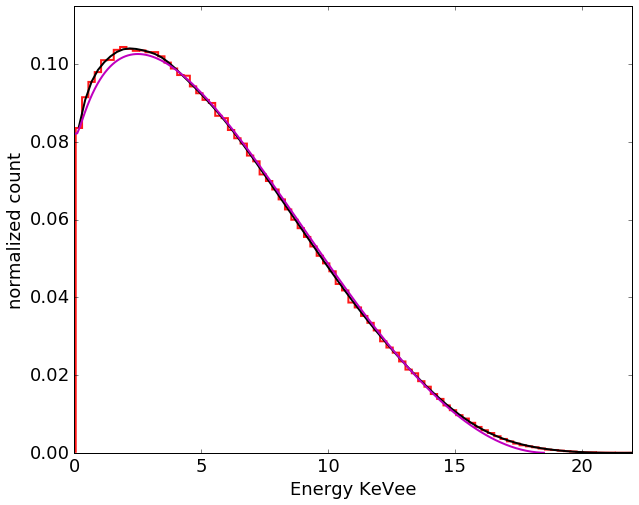

In [19]:
binwidth=0.25 # keV
n_NEST_MAX, bin_edges_NEST_MAX, patches = plt.hist(E_com_Tsim_NEST_MAX, bins=np.arange(0.05, 25 + binwidth, binwidth), normed=1, facecolor='none',edgecolor='red',linewidth=2, histtype='step', alpha=0.9)
plt.xlabel('Energy KeVee',fontsize=18)
plt.ylabel('normalized count',fontsize=18)
plt.xlim([0,25])
left,right = bin_edges_NEST_MAX[:-1],bin_edges_NEST_MAX[1:]
bin_center_NEST_MAX=(right+left)/2

s = ip.UnivariateSpline(bin_center_NEST_MAX,n_NEST_MAX)
s.set_smoothing_factor(1e-5)
plt.plot(bin_center_NEST_MAX,s(bin_center_NEST_MAX),'k',linewidth=2)

scale_factor=sum(N)*0.1/(sum(n_NEST_MAX)*binwidth)
plt.plot(T,N/scale_factor,'m',linewidth=2)

plt.xlim([0,22]);
plt.ylim([0, 1.1*max(n_NEST_MAX)]);

#plt.yscale('log')

(0, 22)

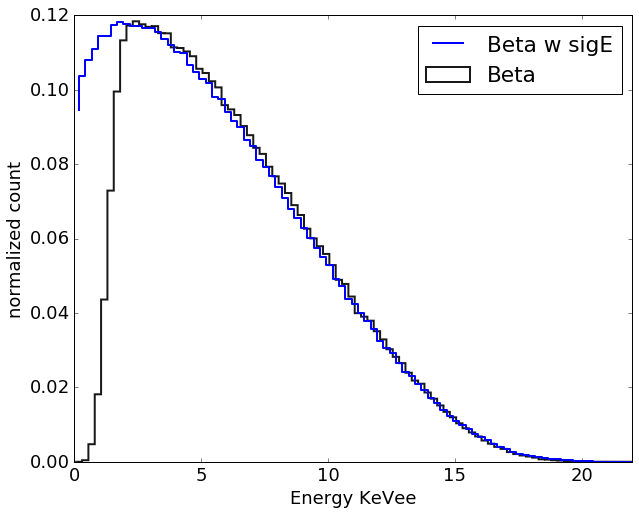

In [20]:
binwidth=0.25 # keV

n_data, bin_edges_data, patches = plt.hist(E_Doke, bins=np.arange(0.05, 25 + binwidth, binwidth), normed=1, facecolor='none',edgecolor='black',linewidth=2, histtype='step', alpha=0.9)
plt.xlabel('Energy KeVee',fontsize=18)
plt.ylabel('normalized count',fontsize=18)

left,right = bin_edges_data[:-1],bin_edges_data[1:]
bin_center_data=(right+left)/2


data_scale_factor=sum(n_data[bin_center_data>3])/sum(n_NEST_MAX[bin_center_NEST_MAX>3])

plt.step(bin_center_NEST_MAX,n_NEST_MAX*data_scale_factor,'b',linewidth=2)
#plt.plot(T,N/scale_factor*data_scale_factor,'m',linewidth=2)

plt.legend(('Beta w sigE','Beta','Data','Data with Beta values'))
plt.xlim([0,22])
#plt.yscale('log')

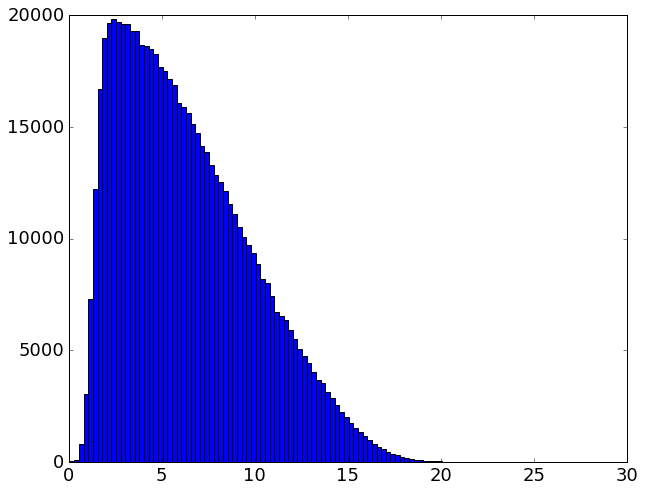

In [21]:
num_data, num_data_bins, num_data_patches=plt.hist(E_Doke,bins=np.arange(0.05, 25 + binwidth, binwidth));

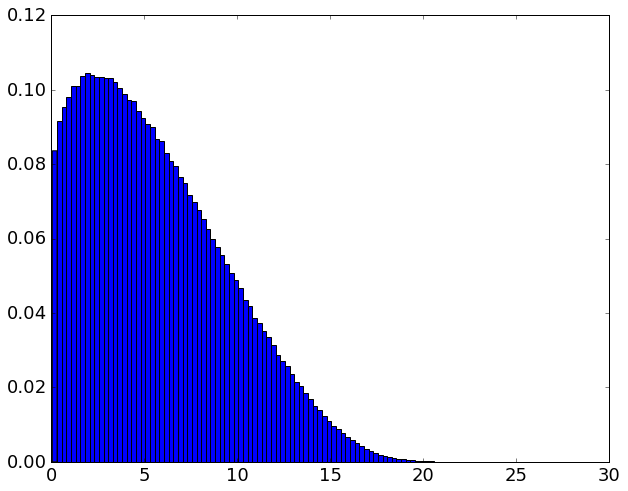

In [22]:
num_sim, num_sim_bins, num_sim_patches= plt.hist(E_com_Tsim_NEST_MAX, bins=np.arange(0.05, 25 + binwidth, binwidth),normed=1);

In [23]:
SimToData_scale_factor=sum(num_data[bin_center_data>3])/sum(num_sim[bin_center_NEST_MAX>3])
frac_res=(num_data-num_sim*SimToData_scale_factor)/sqrt(num_data)

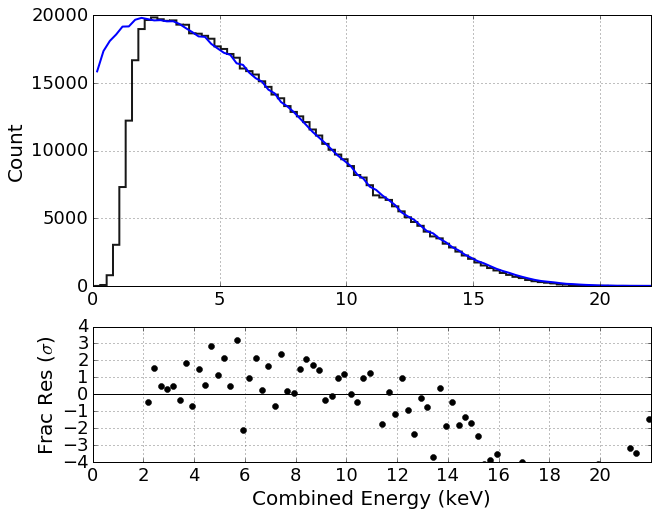

In [24]:
from matplotlib import gridspec

fig = plt.Figure(figsize=(8,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[10,5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.hist(E_Doke,bins=np.arange(0.05, 25 + binwidth, binwidth),facecolor='none',edgecolor='black',linewidth=2, histtype='step', alpha=0.9);
ax1.plot(bin_center_NEST_MAX,num_sim*SimToData_scale_factor,linewidth=2,color='blue')
ax1.set_xlim([0,22])
ax1.grid(True)
ax1.set_ylabel(r'Count',fontsize=20)
for tick in ax1.xaxis.get_major_ticks():
                tick.label.set_fontsize(18) 
for tick in ax1.yaxis.get_major_ticks():
                tick.label.set_fontsize(18) 


ax2.plot(bin_center_NEST_MAX,frac_res,'ko',linewidth=2)
ax2.plot([0,22],[0,0],'k')
ax2.grid(True)
ax2.set_xticks(np.arange(0,22,2))
ax2.set_xlim([0,22])
ax2.set_ylim([-4,4])
ax2.set_ylabel(r'Frac Res ($\sigma$)',fontsize=20)
ax2.set_xlabel('Combined Energy (keV)',fontsize=20)
for tick in ax2.xaxis.get_major_ticks():
                tick.label.set_fontsize(18) 
for tick in ax2.yaxis.get_major_ticks():
                tick.label.set_fontsize(18)  

In [25]:
thresh=num_data/(num_sim*SimToData_scale_factor)
thresh_err=sqrt( (sqrt(num_data)/(num_sim*SimToData_scale_factor))**2 + (num_data/(num_sim*(SimToData_scale_factor**2)))**2)
no_nan_cut=np.logical_not(numpy.isnan(thresh))*np.logical_not(numpy.isinf(thresh))
thresh_nonan=thresh[no_nan_cut]
xbin_nonan=bin_center_NEST_MAX[no_nan_cut]

In [26]:
import scipy
from scipy import optimize

def func(x,mu,sig):
    return (1/2)*scipy.special.erf((x-mu)/(sqrt(2)*sig))+(1/2)

In [27]:
popt, pcov = scipy.optimize.curve_fit(func,xbin_nonan,thresh_nonan)
thresh_yval=(1/2)*scipy.special.erf((bin_center_NEST_MAX-popt[0])/(sqrt(2)*popt[1]))+(1/2)

popt

array([ 1.29117609,  0.370948  ])

In [28]:
popt_err=np.sqrt(np.diag(pcov))
popt_err

array([ 0.20191194,  0.28554841])

//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:2790: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


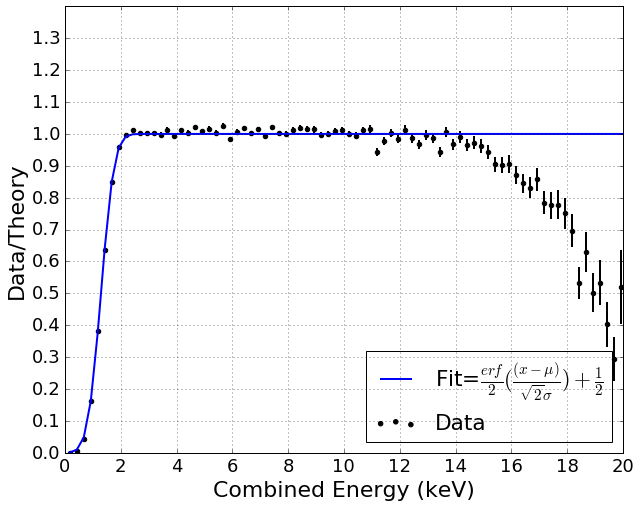

In [29]:
thresh=num_data/(num_sim*SimToData_scale_factor)
thresh_err=sqrt( (sqrt(num_data)/(num_sim*SimToData_scale_factor))**2 + (num_data/(num_sim*(SimToData_scale_factor**2)))**2)
plt.errorbar(bin_center_NEST_MAX,thresh,yerr=thresh_err,xerr=None,ecolor='black',elinewidth=2,capsize=0,fmt=None)
plt.xlim([0,20])
plt.ylim([0,1.4])
plt.scatter(bin_center_NEST_MAX,thresh,c='black',marker='o')
plt.plot(bin_center_NEST_MAX,thresh_yval,linewidth=2)
plt.xticks(np.arange(0,22,2))
plt.yticks(np.arange(0,1.4,0.1))
plt.ylabel('Data/Theory',fontsize=22)
plt.xlabel('Combined Energy (keV)',fontsize=22)
plt.legend((r'Fit=$\frac{erf}{2}(\frac{(x-\mu)}{\sqrt{2}\sigma}) + \frac{1}{2}$','Data'),loc='lower right')


ax=plt.gca()
ax.grid(True)

<h1> Calculate ER Band</h1>

In [30]:
s2s1_sim=log10(S2c/S1c)

S2S1_er_mean=[]
S2S1_er_sig=[]

S1_er_cen=np.arange(1.5,80.5,1)
for s1_bins in S1_er_cen:
    S2S1_er_mean.append(mean(s2s1_sim[(S1c>(s1_bins-0.5))&(S1c<(s1_bins+0.5))]))
    S2S1_er_sig.append(std(s2s1_sim[(S1c>(s1_bins-0.5))&(S1c<(s1_bins+0.5))]))
S2S1_er_mean=np.array(S2S1_er_mean)
S2S1_er_sig=np.array(S2S1_er_sig)

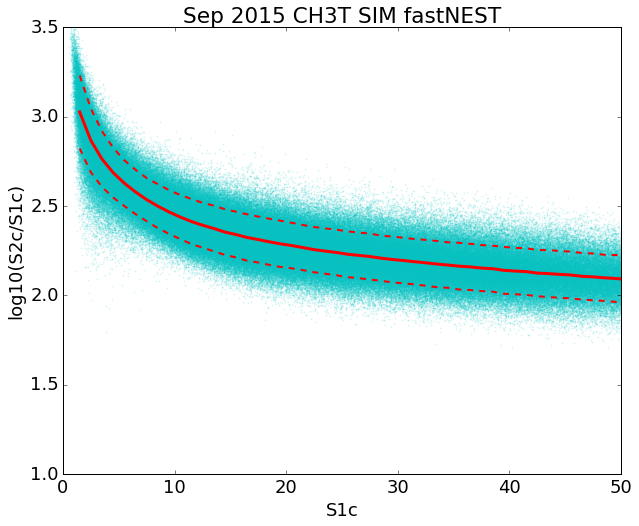

In [31]:
plt.scatter(S1c,s2s1_sim,alpha=0.1,color='c',s=1)
xlabel('S1c')
ylabel('log10(S2c/S1c)')
ylim([1,3.5])
xlim([0,50])
#plot SIM fit
ax2=plt.plot(S1_er_cen,S2S1_er_mean,'-r',linewidth=3)

#plot bands
plt.plot(S1_er_cen,S2S1_er_mean-1.28*S2S1_er_sig,'--r',linewidth=2)
plt.plot(S1_er_cen,S2S1_er_mean+1.28*S2S1_er_sig,'--r',linewidth=2)

plt.title('Sep 2015 CH3T SIM fastNEST')

<h1> Print out Data for Matlab ER Band </h1>

In [32]:
n_NEST_MAX

array([  8.36030049e-02,   9.15206842e-02,   9.54571426e-02,
         9.79822688e-02,   1.01049810e-01,   1.01118270e-01,
         1.03714490e-01,   1.04449120e-01,   1.03946201e-01,
         1.03459081e-01,   1.03561771e-01,   1.03087816e-01,
         1.03135211e-01,   1.02050381e-01,   1.00428403e-01,
         9.89064808e-02,   9.72265741e-02,   9.70527907e-02,
         9.43012194e-02,   9.25370541e-02,   9.08334496e-02,
         9.00435249e-02,   8.67363731e-02,   8.61333972e-02,
         8.30790214e-02,   8.09567569e-02,   7.95875539e-02,
         7.64989481e-02,   7.50191557e-02,   7.16435438e-02,
         6.99531048e-02,   6.77755455e-02,   6.52214554e-02,
         6.26357683e-02,   5.99868872e-02,   5.78040618e-02,
         5.55606754e-02,   5.31066425e-02,   5.07052712e-02,
         4.87515239e-02,   4.67135180e-02,   4.34511287e-02,
         4.17870205e-02,   3.86747169e-02,   3.74108372e-02,
         3.52253787e-02,   3.34506810e-02,   3.14969338e-02,
         2.86953339e-02,

In [33]:
bin_center_NEST_MAX

array([  0.175,   0.425,   0.675,   0.925,   1.175,   1.425,   1.675,
         1.925,   2.175,   2.425,   2.675,   2.925,   3.175,   3.425,
         3.675,   3.925,   4.175,   4.425,   4.675,   4.925,   5.175,
         5.425,   5.675,   5.925,   6.175,   6.425,   6.675,   6.925,
         7.175,   7.425,   7.675,   7.925,   8.175,   8.425,   8.675,
         8.925,   9.175,   9.425,   9.675,   9.925,  10.175,  10.425,
        10.675,  10.925,  11.175,  11.425,  11.675,  11.925,  12.175,
        12.425,  12.675,  12.925,  13.175,  13.425,  13.675,  13.925,
        14.175,  14.425,  14.675,  14.925,  15.175,  15.425,  15.675,
        15.925,  16.175,  16.425,  16.675,  16.925,  17.175,  17.425,
        17.675,  17.925,  18.175,  18.425,  18.675,  18.925,  19.175,
        19.425,  19.675,  19.925,  20.175,  20.425,  20.675,  20.925,
        21.175,  21.425,  21.675,  21.925,  22.175,  22.425,  22.675,
        22.925,  23.175,  23.425,  23.675,  23.925,  24.175,  24.425,
        24.675,  24.

In [42]:
savetxt('/global/homes/r/rknoche/iPyNb/Analysis_Code/Run04_KrypCal2p22_NESTmodel/LibNEST_ERData_S1c.txt',S1c)

In [43]:
savetxt('/global/homes/r/rknoche/iPyNb/Analysis_Code/Run04_KrypCal2p22_NESTmodel/LibNEST_ERData_S2c.txt',S2c)

In [44]:
savetxt('/global/homes/r/rknoche/iPyNb/Analysis_Code/Run04_KrypCal2p22_NESTmodel/LibNEST_ERData_dT.txt',dTus)

In [ ]:
savetxt('/global/homes/r/rknoche/iPyNb/Analysis_Code/Run04_KrypCal2p22_NESTmodel/LibNEST_ERData_s2x_c.txt',S2x)

In [ ]:
savetxt('/global/homes/r/rknoche/iPyNb/Analysis_Code/Run04_KrypCal2p22_NESTmodel/LibNEST_ERData_s2y_c.txt',S2y)